Let's install PyTorch and fastai libraries first. You have to repeat this step every time you restart this notebook in colab.

In [1]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
     |████████████████████████████████| 704.8MB 20kB/s 


In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
hs = pd.read_csv('hatespeech.csv', encoding="latin-1",index_col=6, keep_default_na=False)
#print(hs.head())

orig = pd.read_csv('NAACL_SRW_2016.csv', index_col=0, header=None,encoding='latin-1')
orig.index.name = 'ID'
orig = orig.rename(columns={1: 'Class'})
orig.index = orig.index.astype(str)
#print(orig.head())

#merging the two dataframes
hs = pd.merge(hs, orig, how='inner', left_index=True, right_index=True)
#print(hs.head())
df = hs
from sklearn import model_selection, preprocessing




In [0]:
df_minority_racism = df[df['Class']=='racism']
df_minority_sexism = df[df['Class']=='sexism']
df_majority_neu =  df[df['Class']=='none']
from sklearn.utils import resample

df_minority_upsampled = resample(df_minority_sexism, 
                                 replace=True,     # sample with replacement
                                 n_samples=5000,    # to match majority class
                                 random_state=500) # reproducible results
df_minority_upsampled_racism = resample(df_minority_racism, 
                                 replace=True,     # sample with replacement
                                 n_samples=5000,    # to match majority class
                                 random_state=500) # reproducible results

df = pd.concat([df_majority_neu, df_minority_upsampled_racism, df_minority_upsampled])



In [0]:
encoder = preprocessing.LabelEncoder()
df['Class'] = encoder.fit_transform(df['Class'])


In [0]:
#import dataset
from sklearn.datasets import fetch_20newsgroups
dataset = df
documents = dataset.Tweets

In [0]:
# create a dataframe
df = pd.DataFrame({'label':dataset['Class'],
                   'text':dataset.Tweets})

In [0]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.4, random_state = 12)

In [14]:
df_trn.shape, df_val.shape

((12619, 2), (8414, 2))

### Data Preparation

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.4)

In [17]:
# train the learner object
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.668283,3.990028,0.304678,00:16


In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


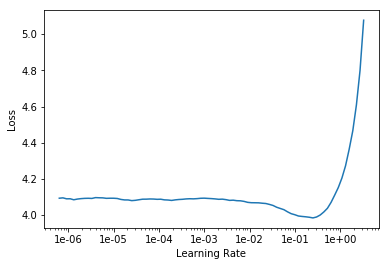

In [19]:
learn.recorder.plot()

In [0]:
learn.save_encoder('ft_enc')

In [21]:
learn = text_classifier_learner(data_clas,arch= AWD_LSTM, drop_mult=0.3)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12619 items)
x: TextList
xxbos @tintinenameriq @maxblumenthal @campagnebds xxmaj shows how stupid you 've become . xxmaj only xxmaj muslim terrorists actually attack talks .,xxbos @98halima @johnnygjokaj @bilalighumman @cdnkhadija @rfrankh53 xxup isis wants to control the world because xxmaj mohammed wanted to control it .,xxbos xxmaj he is not all there . xxmaj and i guess he keeps forgetting that the dog just went outside and ug xxrep 4 h i want to sleep .,xxbos xxmaj oh $ xxunk , xxmaj psycho xxmaj annie is back . > xxunk # xxup mkr,xxbos xxmaj the sexist litmus test is if you call out a lvl 2 sexist comment & & the dood comes back with lvl 10 guns ablazing , " pussy " & & " cunt " & & " bitch "
y: CategoryList
1,1,0,0,2
Path: .;

Valid: LabelList (8414 items)
x: TextList
xxbos xxup rt http : / / t.co / xxunk xxunk xxmaj call me sexist but men will always be superior drivers,xxbos xxup rt @shermertron : xxup @mt8_9 xxunk xxmaj th

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


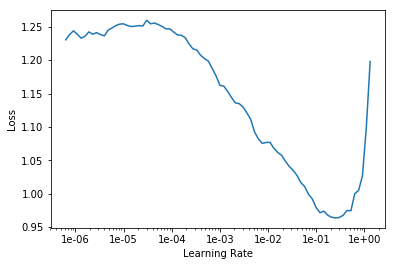

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(50, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.623416,0.566332,0.777157,00:11
1,0.571242,0.510927,0.787259,00:12
2,0.576036,0.480368,0.795341,00:11
3,0.530852,0.471906,0.793677,00:11
4,0.544762,0.478435,0.797362,00:11
5,0.528051,0.460720,0.802115,00:11
6,0.523531,0.466797,0.792132,00:11
7,0.528650,0.470811,0.793440,00:11
8,0.537413,0.446670,0.806988,00:11
9,0.521645,0.465889,0.800214,00:12


In [0]:
learn.fit_one_cycle(100, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.653021,0.574230,0.776206,00:11
1,0.575820,0.501459,0.793083,00:11
2,0.532598,0.469748,0.798669,00:11
3,0.544697,0.468612,0.797837,00:11
4,0.532855,0.455535,0.805206,00:11
5,0.525249,0.456973,0.804136,00:11
6,0.510769,0.454591,0.806870,00:11
7,0.536015,0.437382,0.814476,00:11
8,0.509272,0.451316,0.809484,00:12
9,0.490977,0.438072,0.815427,00:11


In [0]:
#Oversampling

learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.566685,0.517436,0.812689,00:12
1,0.542097,0.527252,0.810773,00:12
2,0.505091,0.498490,0.815614,00:11
3,0.532351,0.505338,0.820960,00:13
4,0.517055,0.495234,0.819044,00:12
5,0.513420,0.522818,0.811580,00:12
6,0.539227,0.505133,0.811983,00:12
7,0.507165,0.496337,0.818439,00:12
8,0.523650,0.505724,0.811882,00:13
9,0.492227,0.489392,0.819649,00:12


In [0]:
# General without preprocessing

learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.691303,0.558598,0.782615,00:08
1,0.644233,0.541855,0.775333,00:08
2,0.642364,0.536564,0.774558,00:08
3,0.631345,0.562451,0.758289,00:08
4,0.612675,0.504514,0.789898,00:08
5,0.624449,0.503726,0.786179,00:08
6,0.616386,0.508229,0.784475,00:08
7,0.616527,0.520840,0.781531,00:08
8,0.618587,0.506106,0.791602,00:08
9,0.602859,0.514996,0.782461,00:08


In [0]:
#drop_mul = 0.3
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.630025,0.577467,0.767293,00:11
1,0.579487,0.528732,0.760043,00:11
2,0.572823,0.497073,0.788210,00:11
3,0.559528,0.490734,0.788448,00:11
4,0.562241,0.468228,0.798431,00:11
5,0.545786,0.467924,0.800333,00:11
6,0.537161,0.477581,0.795222,00:12
7,0.532120,0.457542,0.803066,00:11
8,0.535088,0.454426,0.805206,00:11
9,0.515849,0.477173,0.792370,00:11


In [0]:
learn.fit_one_cycle(50, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.617558,0.548942,0.778227,00:11
1,0.573675,0.502053,0.786546,00:11
2,0.574079,0.487434,0.790349,00:11
3,0.543775,0.478375,0.793202,00:11
4,0.538428,0.483028,0.791419,00:11
5,0.544638,0.464327,0.799976,00:11
6,0.514850,0.461437,0.800808,00:11
7,0.528654,0.447244,0.805443,00:12
8,0.548981,0.446111,0.813525,00:12
9,0.512610,0.452734,0.800570,00:11


In [24]:
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,3658,170,407
1,284,1821,5
2,472,9,1588


In [0]:
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,3922,272,629
1,218,496,3
2,273,6,635


In [0]:
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,3928,188,620
1,298,584,9
2,187,2,638


In [0]:
targets

tensor([0, 0, 0,  ..., 2, 0, 0])

In [0]:
import tensorflow as tf

In [0]:
print (tf.metrics.accuracy(
    targets,
    predictions,
    weights=None,
    metrics_collections=None,
    updates_collections=None,
    name=None
))

(<tf.Tensor 'accuracy_1/value:0' shape=() dtype=float32>, <tf.Tensor 'accuracy_1/update_op:0' shape=() dtype=float32>)


In [0]:
from sklearn.metrics import accuracy_score

In [26]:
# General
accuracy_score(targets, predictions)

0.83990967435227

In [0]:
#Oversamping
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)
accuracy_score(targets, predictions)

0.8233895887806038

In [0]:
pd.crosstab(predictions, targets)


col_0,0,1,2
row_0,,,
0,3623,197,712
1,465,1792,40
2,326,11,1248


In [0]:
# Drop Multitude changed

preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
print (pd.crosstab(predictions, targets))
print (accuracy_score(targets, predictions))

col_0     0     1     2
row_0                  
0      3726   232   512
1       324  1763    16
2       364     5  1472
0.8273116234846684


In [0]:
# Drop Multitude changed 50 epochs

preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
print (pd.crosstab(predictions, targets))
print (accuracy_score(targets, predictions))

col_0     0     1     2
row_0                  
0      3750   163   403
1       312  1833     5
2       352     4  1592
0.8527454242928453


In [0]:
# Drop Multitude changed 100 epochs

preds, targets = learn_model.get_preds()

predictions = np.argmax(preds, axis = 1)
print (pd.crosstab(predictions, targets))
print (accuracy_score(targets, predictions))

col_0     0     1     2
row_0                  
0      3800   227   630
1       319  1766     8
2       295     7  1362
0.8233895887806038


# Saving ULMFit Model

In [0]:
learn_instance = learn

In [0]:
learn_instance.save('model')

In [0]:
learn_model = text_classifier_learner(data_clas,arch= AWD_LSTM, drop_mult=0.3)


In [0]:
data_clas.save("data_save.pkl")

In [33]:
data_clas = load_data('./')

learn_model = text_classifier_learner(data_clas,arch= AWD_LSTM, drop_mult=0.3)
learn_model.load("model")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12619 items)
x: TextList
xxbos @tintinenameriq @maxblumenthal @campagnebds xxmaj shows how stupid you 've become . xxmaj only xxmaj muslim terrorists actually attack talks .,xxbos @98halima @johnnygjokaj @bilalighumman @cdnkhadija @rfrankh53 xxup isis wants to control the world because xxmaj mohammed wanted to control it .,xxbos xxmaj he is not all there . xxmaj and i guess he keeps forgetting that the dog just went outside and ug xxrep 4 h i want to sleep .,xxbos xxmaj oh $ xxunk , xxmaj psycho xxmaj annie is back . > xxunk # xxup mkr,xxbos xxmaj the sexist litmus test is if you call out a lvl 2 sexist comment & & the dood comes back with lvl 10 guns ablazing , " pussy " & & " cunt " & & " bitch "
y: CategoryList
1,1,0,0,2
Path: .;

Valid: LabelList (8414 items)
x: TextList
xxbos xxup rt http : / / t.co / xxunk xxunk xxmaj call me sexist but men will always be superior drivers,xxbos xxup rt @shermertron : xxup @mt8_9 xxunk xxmaj th